Deep Learning Fall 2022 Midterm Project

Lucia Rhode and Nicole Joseph

Based on “Adversarial Autoencoders” by Makhzani et al. 



In [ ]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Flatten, Dense, Lambda, LeakyReLU, Reshape
from keras.models import Sequential, Model
from keras.optimizers import Adam
import keras.backend as K
from keras import losses

In [ ]:
# Load dataset
from keras.datasets import mnist
# Note: The labels will be unused; only the MNIST images will be used
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

In [ ]:
# Summarize loaded dataset
print('Train: X=%s, Y=%s' % (X_train.shape, Y_train.shape))
print('Test: X=%s, Y=%s' % (X_test.shape, Y_test.shape))

Train: X=(60000, 28, 28), Y=(60000,)
Test: X=(10000, 28, 28), Y=(10000,)


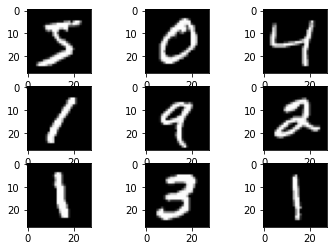

In [ ]:
# Plot the first few images
for i in range(9):
	plt.subplot(330 + 1 + i)
	plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
plt.show()

In [ ]:
# Rescale data 
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = X_train.reshape(60000, 28, 28, 1)

In [ ]:
EPOCHS = 5000
BATCH_SIZE = 128

#Define Encoder Structure

In [ ]:
# The encoder maps inputs to the latent space 
def sample_z(args):
    mu, log_var = args
    batch = K.shape(mu)[0]
    eps = K.random_normal(shape=(batch, 2), mean = 0., stddev = 1.)
    return mu + K.exp(log_var / 2) * eps

In [ ]:
# The encoder compresses the input images, mapping it to a representation with meaningful characteristics.
# The encoder, decoder, and discriminator are composed of densely connected layers; Leaky ReLU was chosen for the activation function
def build_encoder():
  img = Input(shape=(28, 28, 1))
  h = Flatten()(img)
  h = Dense(512)(h)
  h = Dense(512)(h)
  h = LeakyReLU(alpha=0.2)(h)
  h = Dense(512)(h)
  h = LeakyReLU(alpha=0.2)(h)
  mu = Dense(2)(h)
  log_var = Dense(2)(h)
  latent_space = Lambda(sample_z)([mu, log_var])
  return Model(img, latent_space)

#Define Decoder Structure

The decoder transforms the output of the encoder, therefore reconstructing the original input images and simultaneously behaving as the generator.

In [ ]:

def build_decoder():
    model = Sequential()
    model.add(Dense(512, input_dim=2))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(np.prod((28, 28, 1)), activation = 'tanh'))
    model.add(Reshape((28, 28, 1)))
    z = Input(shape = (2,))
    img = model(z)
    return Model(z, img)

#Define Discriminator Structure

The architecture involves training and optimizing the discriminator to tell the difference between samples drawn from the prior distribution and samples drawn from the encoder distribution. 

In [ ]:
def build_discriminator():
    model = Sequential()
    model.add(Dense(512, input_dim=2))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dense(1, activation = "sigmoid"))
    encoded_repr = Input(shape = (2, ))
    validity = model(encoded_repr)
    return Model(encoded_repr, validity)

In [ ]:
discriminator = build_discriminator()
encoder = build_encoder()
decoder = build_decoder()

# The discriminator is updated using a binary cross-entropy loss based on its ability to separate 
# "real" (from the dataset) and "fake" (generated) images 
optimizer = Adam(0.0002, 0.5)
discriminator.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics=['accuracy'])   

In [ ]:
# Make weights in the discriminator not trainable
discriminator.trainable = False

#Adversarial Autoencoder

In [ ]:
# These sources below were helpful in explaining the basic building blocks of an adversarial autoencoder and how they interact with each other
# citations: https://hjweide.github.io/adversarial-autoencoders
# https://rubikscode.net/2019/01/21/generating-images-using-adversarial-autoencoders-and-python/#:~:text=In%20a%20nutshell%2C%20Adversarial%20Autoencoders,there%20in%20the%20previous%20article 

def build_aae(encoder, decoder, discriminator):
  img = Input(shape = (28, 28, 1))
  latent_space = encoder(img)
  reconstructed = decoder(latent_space)

  validity = discriminator(latent_space)
  adversarial_autoencoder = Model(img, [reconstructed, validity])
  
  return adversarial_autoencoder

#Adversarial Autoencoder Loss

The discriminator is a binary classifier and is trained using the binary cross-entropy loss function. A limitation of this loss function is that it is primarily concerned with whether the predictions are correct or not. A mean squared error, or L2 loss function, for the discriminator model adds insight to how correct or incorrect the predictions might be.

In [ ]:
# citations: https://machinelearningmastery.com/least-squares-generative-adversarial-network/
# https://rubikscode.net/2019/01/21/generating-images-using-adversarial-autoencoders-and-python/#:~:text=In%20a%20nutshell%2C%20Adversarial%20Autoencoders,there%20in%20the%20previous%20article.

adversarial_autoencoder = build_aae(encoder, decoder, discriminator)
adversarial_autoencoder.compile(loss = ['mse', 'binary_crossentropy'],  loss_weights=[0.999, 0.001], optimizer = optimizer)

In [ ]:
encoder.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 flatten_1 (Flatten)            (None, 784)          0           ['input_6[0][0]']                
                                                                                                  
 dense_14 (Dense)               (None, 512)          401920      ['flatten_1[0][0]']              
                                                                                                  
 dense_15 (Dense)               (None, 512)          262656      ['dense_14[0][0]']               
                                                                                            

In [ ]:
decoder.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 2)]               0         
                                                                 
 sequential_3 (Sequential)   (None, 28, 28, 1)         666384    
                                                                 
Total params: 666,384
Trainable params: 666,384
Non-trainable params: 0
_________________________________________________________________


In [ ]:
discriminator.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 2)]               0         
                                                                 
 sequential_2 (Sequential)   (None, 1)                 133121    
                                                                 
Total params: 133,121
Trainable params: 0
Non-trainable params: 133,121
_________________________________________________________________


In [ ]:
adversarial_autoencoder.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 model_5 (Functional)           (None, 2)            929284      ['input_8[0][0]']                
                                                                                                  
 model_6 (Functional)           (None, 28, 28, 1)    666384      ['model_5[0][0]']                
                                                                                                  
 model_4 (Functional)           (None, 1)            133121      ['model_5[0][0]']                
                                                                                            

In [ ]:
# The discriminator is used to train the generator model. 
# The generator is updated in such a way that it is encouraged to generate images that are more likely to fool the discriminator.

# Adversarial ground truths:
valid = np.ones((BATCH_SIZE, 1))
fake = np.zeros((BATCH_SIZE, 1))

##Fitting to a Guassian Distribution

The functions below ensure that the encoder outputs to follow a known prior distribution (in this case, it's Guassian). 
Therefore, we get continuous data in the latent space; the code is evenly distributed over the prior distribution.

In [ ]:
# citation: https://github.com/mrquincle/keras-adversarial-autoencoders/blob/master/Keras%20Adversarial%20Autoencoder%20MNIST.ipynb

def sample_prior(batch_size):
    return np.random.normal(size=(batch_size, 2))

In [ ]:
def sample_images(decoder, epoch):
  
    r, c = 5, 5
    z = sample_prior(r*c)
    gen_imgs = decoder.predict(z)
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/mnist_%d.png" % epoch)
    plt.close()

#Training

In [ ]:
for epoch in range(EPOCHS):
  idx = np.random.randint(0, X_train.shape[0], BATCH_SIZE)
  img_batch = X_train[idx]

  latent_fake = encoder.predict(img_batch)
  latent_real = sample_prior(BATCH_SIZE)

  # Train the discriminator
  d_loss_real = discriminator.train_on_batch(latent_real, valid)
  d_loss_fake = discriminator.train_on_batch(latent_fake, fake)
  d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

  # Train the generator
  g_loss = adversarial_autoencoder.train_on_batch(img_batch, [img_batch, valid])
  
  # Plot the progress 
  if epoch % 10 == 0:
    print ("%d [D loss: %f, acc: %.2f%%] [G loss: %f, mse: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0], g_loss[1]))
    
  # Save generated images 
  if epoch % 100 == 0:
    sample_images(decoder, epoch)


Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 4ms/step
500 [D loss: 0.494419, acc: 75.78%] [G loss: 0.208677, mse: 0.206001]
4/4 [==============================] - 0s 3ms/step
510 [D loss: 0.368095, acc: 84.77%] [G loss: 0.195848, mse: 0.192504]
4/4 [==============================] - 0s 4ms/step
520 [D loss: 0.469660, acc: 75.78%] [G loss: 0.199091, mse: 0.196309]
4/4 [==============================] - 0s 3ms/step
530 [D loss: 0.495465, acc: 73.83%] [G loss: 0.212623, mse: 0.209410]
4/4 [==============================] - 0s 4ms/step
540 [D loss: 0.436624, acc: 78.91%] [G loss: 0.207140, mse: 0.204696]
4/4 [==============================] - 0s 3ms/step
550 [D loss: 0.452700, acc: 76.95%] [G loss: 0.206184, mse: 0.203594]
4/4 [==============================] - 0s 3ms/step
560 [D loss: 0.382117, acc: 81.25%] [G loss: 0.195163, mse: 0.191958]
4/4 [==============================] - 0s 2ms/step
570 [D loss: 0.408535, acc: 80.08%] [G loss: 0.2006

#Plot Latent Space Distribution

79/79 [==============================] - 0s 2ms/step


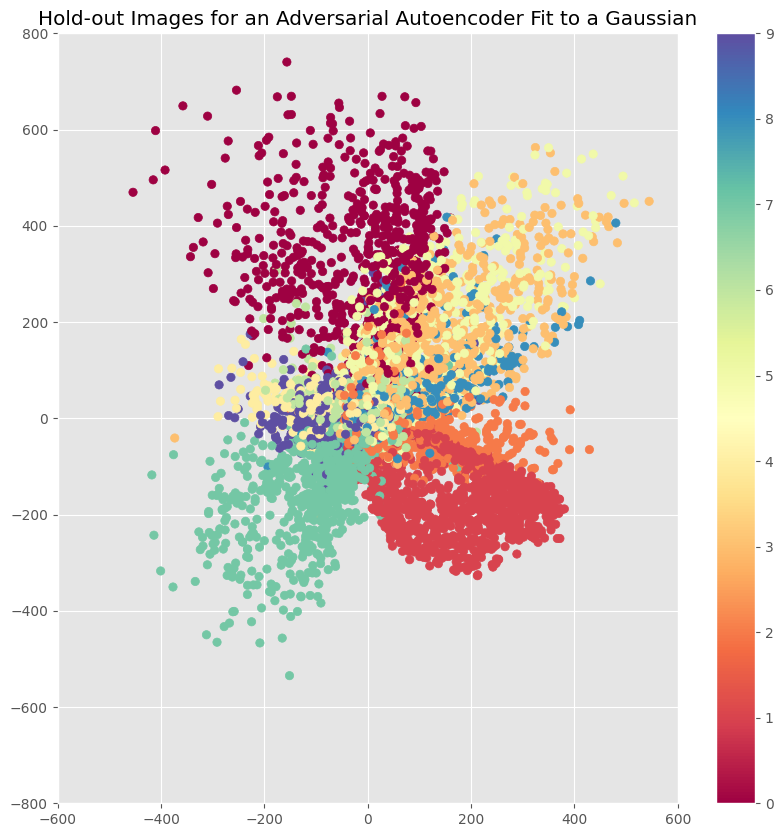

In [ ]:
# citation: https://blog.keras.io/building-autoencoders-in-keras.html

# Use MNIST test data as input to the encoder
x_test_encoded = encoder.predict(X_test, batch_size = BATCH_SIZE)

with plt.style.context(['default','ggplot'], after_reset = True):
    plt.figure(figsize = (10, 10))
    plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=Y_test, cmap='Spectral')
    plt.colorbar()
    plt.xlim(-600, 600)
    plt.ylim(-800, 800)
    plt.title('Hold-out Images for an Adversarial Autoencoder Fit to a Gaussian')
    plt.show()

#Manifold of Adversarial Autoencoder

4/4 [==============================] - 0s 3ms/step


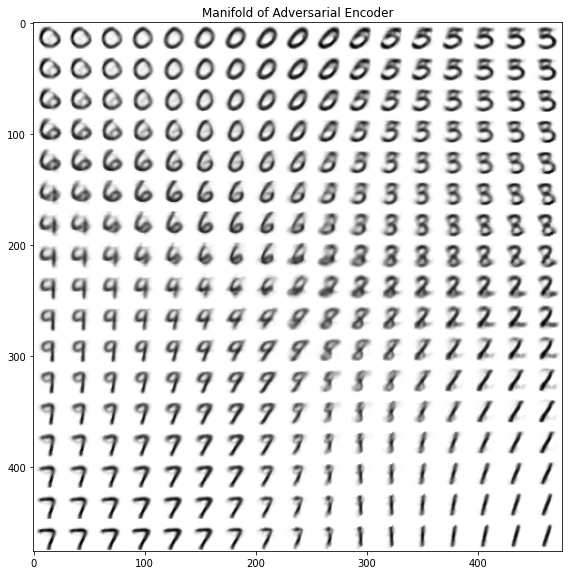

In [ ]:
# citation: https://blog.keras.io/building-autoencoders-in-keras.html
nx = ny = 17
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]]*BATCH_SIZE)
        x_mean = decoder.predict(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.title("Manifold of Adversarial Encoder")
plt.imshow(canvas, origin="upper", cmap="gray_r")
plt.tight_layout()